In [16]:
import math
import warnings
from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
from matplotlib.pyplot import style
from scipy.stats import boxcox
import statsmodels.api as sm
# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
plt.style.use('ggplot')
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std


# Suppress annoying harmless error.
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
data_path = 'file:///C:/Users/JChaotogo/Desktop/New%20folder/nycrimedata.xls'
df = pd.read_excel(data_path)
df.columns = ['city', 'population', 'violentcrime', 'murder', 'raperevised', 'rapelegacy', 'robbery', 'assault', 'propertycrime', 'burglary', 'larceny', 'motortheft', 'arson']

display(df.head())

print(df.dtypes)

,city,population,violentcrime,murder,raperevised,rapelegacy,robbery,assault,propertycrime,burglary,larceny,motortheft,arson
0,NEW YORK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Offenses Known to Law Enforcement,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"by City, 2013",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,City,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape\n(revised\ndefinition)1,Rape\n(legacy\ndefinition)2,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson3
4,Adams Village,1861,0,0,NaN,0,0,0,12,2,10,0,0


city             object
population       object
violentcrime     object
murder           object
raperevised      object
rapelegacy       object
robbery          object
assault          object
propertycrime    object
burglary         object
larceny          object
motortheft       object
arson            object
dtype: object


We can remove the first 4 rows as they dont contain any information. The raperevised column only contains one entry, so we can choose to drop this column.

In [3]:
df.drop(df.index[[0, 1, 2, 3]], inplace=True)
df.drop(columns='raperevised', inplace=True)
df.reset_index()
display(df.head())
print(df.dtypes)

,city,population,violentcrime,murder,rapelegacy,robbery,assault,propertycrime,burglary,larceny,motortheft,arson
4,Adams Village,1861,0,0,0,0,0,12,2,10,0,0
5,Addison Town and Village,2577,3,0,0,0,3,24,3,20,1,0
6,Akron Village,2846,3,0,0,0,3,16,1,15,0,0
7,Albany,97956,791,8,30,227,526,4090,705,3243,142,NaN
8,Albion Village,6388,23,0,3,4,16,223,53,165,5,NaN


city             object
population       object
violentcrime     object
murder           object
rapelegacy       object
robbery          object
assault          object
propertycrime    object
burglary         object
larceny          object
motortheft       object
arson            object
dtype: object


# Data Cleaning
We want to replace the objects representing numbers to numeric and clean up any special characters that may interfere with the data analysis

In [4]:
df['popsquared'] = df['population']**2
for column in df:
    if column not in 'city':
        df[column] = pd.to_numeric(df[column])
df.drop(df.index[[348, 349, 350]], inplace=True)
df.tail()

,city,population,violentcrime,murder,rapelegacy,robbery,assault,propertycrime,burglary,larceny,motortheft,arson,popsquared
347,Woodbury Town,10685.000,3.000,0.000,0.000,2.000,1.000,541.000,9.000,529.000,3.000,nan,114169225.000
348,Woodridge Village,829.000,7.000,0.000,0.000,0.000,7.000,17.000,8.000,9.000,0.000,0.000,687241.000
349,Woodstock Town,5931.000,2.000,0.000,0.000,0.000,2.000,58.000,13.000,45.000,0.000,nan,35176761.000
350,Yonkers,199134.000,1036.000,6.000,25.000,390.000,615.000,2368.000,470.000,1662.000,236.000,10.000,39654349956.000
351,Yorktown Town,36643.000,15.000,0.000,0.000,2.000,13.000,334.000,45.000,287.000,2.000,nan,1342709449.000


In [5]:
df.dtypes

city              object
population       float64
violentcrime     float64
murder           float64
rapelegacy       float64
robbery          float64
assault          float64
propertycrime    float64
burglary         float64
larceny          float64
motortheft       float64
arson            float64
popsquared       float64
dtype: object

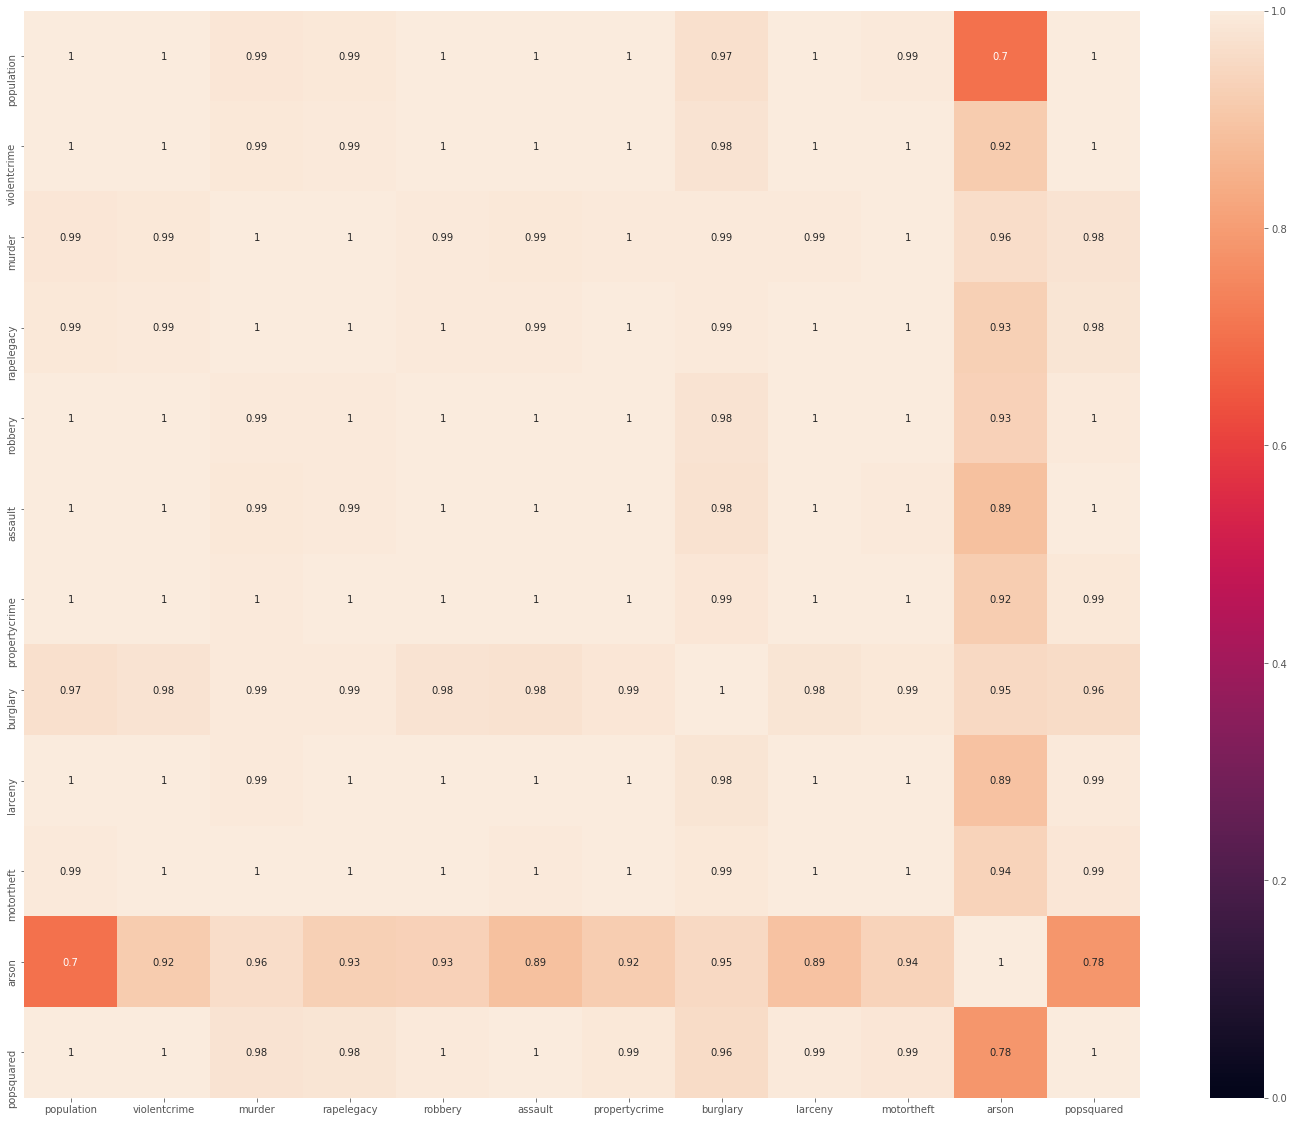

In [6]:
plt.subplots(figsize=(25,20))
sns.heatmap(df.corr(), annot=True, vmin=0, vmax=1)

Based on the heatmap above, the default features are useless for linear regression because they all highly correlate with each other. We have to engineer new features in order to predict property crime rates.

In [7]:
#Manipulate variables to add a violent crime/person feature.
df['percapita_vcrime'] = df['violentcrime']/df['population']
df['murder'] = np.where((df['murder']>0), 1, 0)
df.head()

,city,population,violentcrime,murder,rapelegacy,robbery,assault,propertycrime,burglary,larceny,motortheft,arson,popsquared,percapita_vcrime
4,Adams Village,1861.000,0.000,0,0.000,0.000,0.000,12.000,2.000,10.000,0.000,0.000,3463321.000,0.000
5,Addison Town and Village,2577.000,3.000,0,0.000,0.000,3.000,24.000,3.000,20.000,1.000,0.000,6640929.000,0.001
6,Akron Village,2846.000,3.000,0,0.000,0.000,3.000,16.000,1.000,15.000,0.000,0.000,8099716.000,0.001
7,Albany,97956.000,791.000,1,30.000,227.000,526.000,4090.000,705.000,3243.000,142.000,nan,9595377936.000,0.008
8,Albion Village,6388.000,23.000,0,3.000,4.000,16.000,223.000,53.000,165.000,5.000,nan,40806544.000,0.004


count   348.000
mean      0.032
std       0.023
min       0.000
25%       0.019
50%       0.029
75%       0.043
max       0.123
Name: percapita_vcrime, dtype: float64

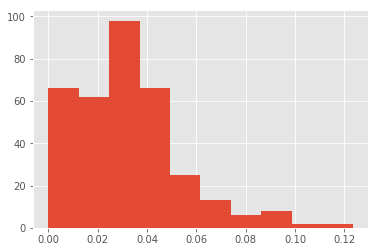

In [8]:
plt.hist(np.sqrt(df.percapita_vcrime))
np.sqrt(df.percapita_vcrime).describe()

In [9]:
df['sqrtcrimepercap'] = np.sqrt(df.percapita_vcrime)

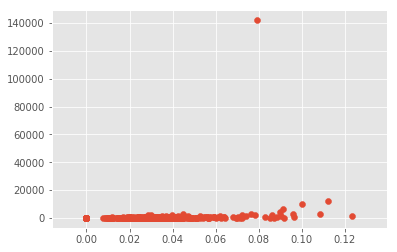

In [10]:
#Test linear relationship between outcome and feature.
plt.scatter(x=np.sqrt(df.percapita_vcrime), y=df.propertycrime)

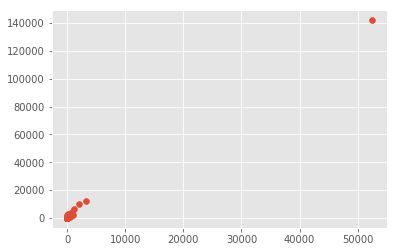

In [11]:
plt.scatter(x=df.violentcrime, y=df.propertycrime)

In [12]:
regr = linear_model.LinearRegression()
Y = df['propertycrime'].values.reshape(-1, 1)
X = df[['population', 'sqrtcrimepercap', 'murder']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[1.68372052e-02 1.16191419e+04 3.14931551e+02]]

Intercept: 
 [-297.46394878]

R-squared:
0.9943312053224423


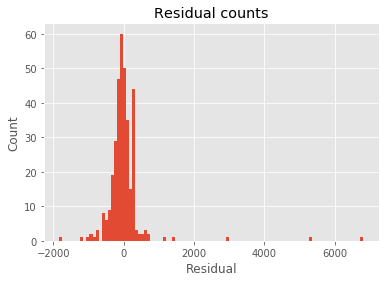

In [13]:
#Test Normality of residual. There appear to be a few outliers, but the residual data looks to be mostly normal.
predicted = regr.predict(X).ravel()
actual = df['propertycrime']
residual = actual - predicted

plt.hist(residual, bins=100)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

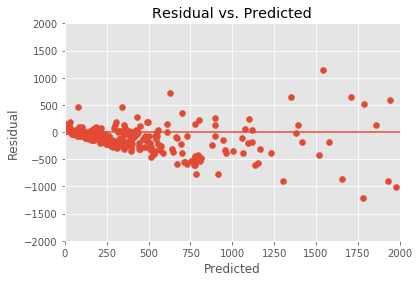

In [14]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.ylim(-2000,2000)
plt.xlim(0,2000)
plt.title('Residual vs. Predicted')
plt.show()

#Residual vs Predicted looks to be homoscedastic

In [15]:
#Test for multicollinearity
correlation_matrix = X.corr()
display(correlation_matrix)
#There also seems to be rather low collinearity.

,population,sqrtcrimepercap,murder
population,1.000,0.137,0.162
sqrtcrimepercap,0.137,1.000,0.460
murder,0.162,0.460,1.000


In [22]:
lin = 'propertycrime ~ population+sqrtcrimepercap+murder'

lm = smf.ols(formula=lin, data=df).fit()
print('Parameters:\n',lm.params,'\n\nP-values:\n',lm.pvalues,'\n\nRsquared:\n',lm.rsquared)

Parameters:
 Intercept          -297.464
population            0.017
sqrtcrimepercap   11619.142
murder              314.932
dtype: float64 

P-values:
 Intercept         0.000
population        0.000
sqrtcrimepercap   0.000
murder            0.002
dtype: float64 

Rsquared:
 0.9943312053224425


In [26]:
print('95% Interval\n',lm.conf_int())

95% Interval
                        0         1
Intercept       -404.720  -190.207
population         0.017     0.017
sqrtcrimepercap 8568.782 14669.502
murder           115.939   513.924


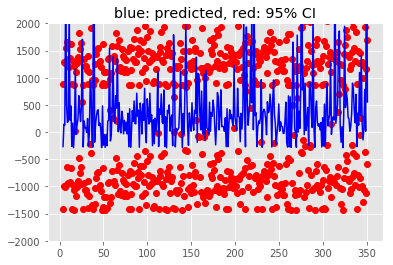

In [35]:
prstd, iv_l, iv_u = wls_prediction_std(lm)

plt.figure()
plt.plot(iv_u, 'o', color='r')
plt.plot(iv_l, 'o', color='r')
plt.plot(lm.fittedvalues, color='b')
plt.title('blue: predicted, red: 95% CI')
plt.ylim(-2000, 2000)
plt.show()

# Import 2013 California Crime Data

Here we're going to test the accuracy of the linear regression model by testing it on crime data from 2013 in California.

In [38]:
cdf = pd.read_excel('file:///C:/Users/JChaotogo/Desktop/Unit2DB/californiacrime.xls')
cdf.head()

,Table 8,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12
0,CALIFORNIA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Offenses Known to Law Enforcement,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"by City, 2013",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,City,Population,Violent\ncrime,Murder and\nnonnegligent\nmanslaughter,Rape\n(revised\ndefinition)1,Rape\n(legacy\ndefinition)2,Robbery,Aggravated\nassault,Property\ncrime,Burglary,Larceny-\ntheft,Motor\nvehicle\ntheft,Arson
4,Adelanto,31165,198,2,NaN,15,52,129,886,381,372,133,17


# Data Cleaning

In [46]:
#cdf.drop(cdf.index[[466, 467, 0, 1, 2, 3]], inplace=True)
cdf.columns = ['city', 'population','violentcrime', 'murder', 'raperevised', 'rape', 'robbery', 'assault', 'propertycrime', 'burglary', 'larceny', 'motortheft', 'arson']
cdf.head()

,city,population,violentcrime,murder,raperevised,rape,robbery,assault,propertycrime,burglary,larceny,motortheft,arson
4,Adelanto,31165,198,2,NaN,15,52,129,886,381,372,133,17
5,Agoura Hills,20762,19,0,NaN,2,10,7,306,109,185,12,7
6,Alameda,76206,158,0,NaN,10,85,63,1902,287,1285,330,17
7,Albany,19104,29,0,NaN,1,24,4,557,94,388,75,7
8,Alhambra,84710,163,1,NaN,9,81,72,1774,344,1196,234,7


In [60]:
#raperevised has 0 entries, so we're going to drop the column.
#cdf.drop(['raperevised'], axis=1, inplace=True)
cdf.dtypes
#The columns are all objects, we're going to convert them to numerics.
for column in cdf:
    if column not in 'city':
        cdf[column] = pd.to_numeric(cdf[column])
cdf.head()
cdf['sqrtcrimepercap'] = np.sqrt(cdf.violentcrime/cdf.population)

In [64]:
#lin is the linear formula obtained by fitting the 2013 NYC. We're going to use that same forumla to run a prediction on
#the 2013 California crime dataset.
lm = smf.ols(formula=lin, data=cdf).fit()
print('Parameters:\n',lm.params,'\n\nP-values:\n',lm.pvalues,'\n\nRsquared:\n',lm.rsquared)

Parameters:
 Intercept         -101.150
population           0.018
sqrtcrimepercap   7543.708
murder             107.365
dtype: float64 

P-values:
 Intercept         0.523
population        0.000
sqrtcrimepercap   0.001
murder            0.000
dtype: float64 

Rsquared:
 0.9027951420889502
